This notebook follows this article:
https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/corpus'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
df = pd.read_csv('output_en.csv', nrows=99999) # limiting the rows
df.head()

,Label,Text
0,GUE-NGL,Heralded as ‘a stage further in the opening of...
1,PPE-DE,"Mr President, on the evening of 12 August, my ..."
2,PPE-DE,"Mr President, this amendment is redundant, as ..."
3,PPE-DE,"Madam President, Commissioner, today is an imm..."
4,PSE,"Mr President, Commissioner, ladies and gentlem..."


For this project, we need only two columns — “Product” and “Consumer complaint narrative”.

Input: Consumer_complaint_narrative
Example: “ I have outdated information on my credit report that I have previously disputed that has yet to be removed this information is more then seven years old and does not meet credit reporting requirements”

Output: product
Example: Credit reporting

We will remove missing values in “Consumer complaints narrative” column, and add a column encoding the product as an integer because categorical variables are often better represented by integers than strings.
We also create a couple of dictionaries for future use.

In [3]:
df['category_id'] = df['Label'].factorize()[0]
from io import StringIO
category_id_df = df[['Label', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Label']].values)

In [4]:
category_to_id

{'GUE-NGL': 0, 'PPE-DE': 1, 'PSE': 2, 'ELDR': 3, 'Verts-ALE': 4}

In [5]:
df.head()

,Label,Text,category_id
0,GUE-NGL,Heralded as ‘a stage further in the opening of...,0
1,PPE-DE,"Mr President, on the evening of 12 August, my ...",1
2,PPE-DE,"Mr President, this amendment is redundant, as ...",1
3,PPE-DE,"Madam President, Commissioner, today is an imm...",1
4,PSE,"Mr President, Commissioner, ladies and gentlem...",2


<Figure size 800x600 with 0 Axes>

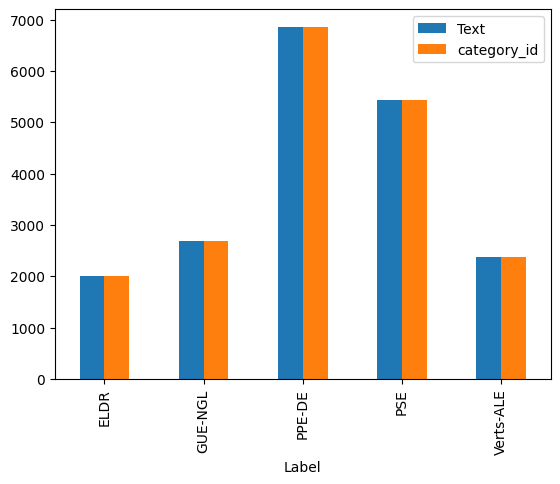

In [6]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Label').count().plot.bar(ylim=0)
plt.show()

The data looks imbalanced. 

When we encounter such problems, we are bound to have difficulties solving them with standard algorithms. Conventional algorithms are often biased towards the majority class, not taking the data distribution into consideration. In the worst case, minority classes are treated as outliers and ignored. 

For some cases, such as fraud detection or cancer prediction, we would need to carefully configure our model or artificially balance the dataset, for example by undersampling or oversampling each class.

However, in our case of learning imbalanced data, the majority classes might be of our great interest. It is desirable to have a classifier that gives high prediction accuracy over the majority class, while maintaining reasonable accuracy for the minority classes. Therefore, we will leave it as it is.

We will calculate a measure called Term Frequency, Inverse Document Frequency, abbreviated to tf-idf. 

We will use sklearn.feature_extraction.text.TfidfVectorizer to calculate a tf-idf vector for each of consumer complaint narratives:
1. sublinear_df is set to True to use a logarithmic form for frequency.
1. min_df is the minimum numbers of documents a word must be present in to be kept.
1. norm is set to l2, to ensure all our feature vectors have a euclidian norm of 1.
1. ngram_range is set to (1, 2) to indicate that we want to consider both unigrams and bigrams.
1. stop_words is set to "english" to remove all common pronouns ("a", "the", ...) to reduce the number of noisy features.

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer


##每个条目，检查它是否是字符串类型。如果不是字符串（例如，是浮点数），则将其转换为字符串
df['Text'] = df['Text'].apply(lambda x: str(x) if not isinstance(x, str) else x)

tfidfVector = TfidfVectorizer(sublinear_tf=True, min_df=50, norm='l2', encoding='utf-8', ngram_range=(1, 2), stop_words='english')

features = tfidfVector.fit_transform(df['Text']).toarray()
labels = df.category_id
features.shape

(19370, 7243)

In [11]:
df['Text'].apply(type).value_counts()

Text
<class 'str'>    19370
Name: count, dtype: int64

In [14]:
# We can use sklearn.feature_selection.chi2 to find the terms that are the most correlated with each of the products:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for Label, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidfVector.get_feature_names_out())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(Label))
    print(" Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print(" Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'ELDR':
 Most correlated unigrams:
. democrat
. liberal
 Most correlated bigrams:
. democrat reform
. liberal democrat
# 'GUE-NGL':
 Most correlated unigrams:
. profits
. εu
 Most correlated bigrams:
. communist party
. party greece
# 'PPE-DE':
 Most correlated unigrams:
. elderly
. pensioners
 Most correlated bigrams:
. president voted
. pensioners party
# 'PSE':
 Most correlated unigrams:
. socialists
. socialist
 Most correlated bigrams:
. socialist group
. social democrats
# 'Verts-ALE':
 Most correlated unigrams:
. wales
. scotland
 Most correlated bigrams:
. sustainable development
. basque country


/home/yidi/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['quelqu'] not in stop_words.
  warnings.warn(


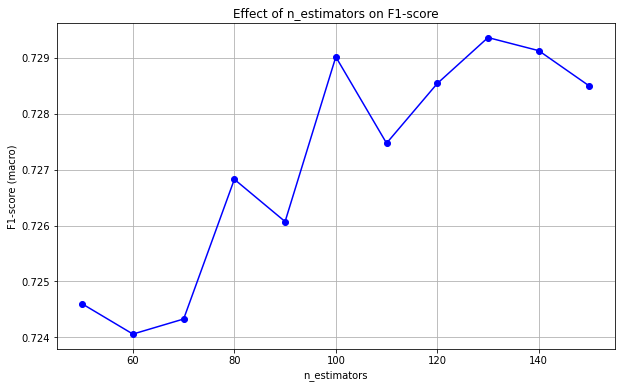

In [11]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt

# Load stop words from file
with open('sw_fr.txt', 'r', encoding='utf-8') as file:
    stop_words = [line.strip() for line in file]

# Load training data
train_data = pd.read_csv('output_fr.csv')

# Load test data
test_data = pd.read_csv('test_fr.csv')

# Define features (X) and target variable (y) for training data
X_train = train_data['Text']
y_train = train_data['Label']

# Define features (X) and target variable (y) for test data
X_test = test_data['Text']
y_test = test_data['Label']

# Create CountVectorizer with custom French stop words
vectorizer = CountVectorizer(
    stop_words=stop_words
)

# Fit and transform the training data
X_train_count = vectorizer.fit_transform(X_train)

# Transform the test data
X_test_count = vectorizer.transform(X_test)

# Initialize RandomForestClassifier
max_depth = 80

# Lists to store F-scores and corresponding parameter values
n_estimators_values = []
f1_scores = []

# Iterate over n_estimators values
for n_estimators in range(50, 151, 10):
    # Initialize RandomForestClassifier with the current parameters
    random_forest = RandomForestClassifier(random_state=42, n_estimators=n_estimators, max_depth=max_depth)

    # Train the model on the training set
    random_forest.fit(X_train_count, y_train)

    # Make predictions on the test set
    y_pred = random_forest.predict(X_test_count)

    # Get F1-score (macro) for the current model
    current_f1_score = f1_score(y_test, y_pred, average='macro')

    # Store values in lists
    n_estimators_values.append(n_estimators)
    f1_scores.append(current_f1_score)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_values, f1_scores, marker='o', linestyle='-', color='b')
plt.title('Effect of n_estimators on F1-score')
plt.xlabel('n_estimators')
plt.ylabel('F1-score (macro)')
plt.grid(True)
plt.show()


/home/yidi/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['quelqu'] not in stop_words.
  warnings.warn(


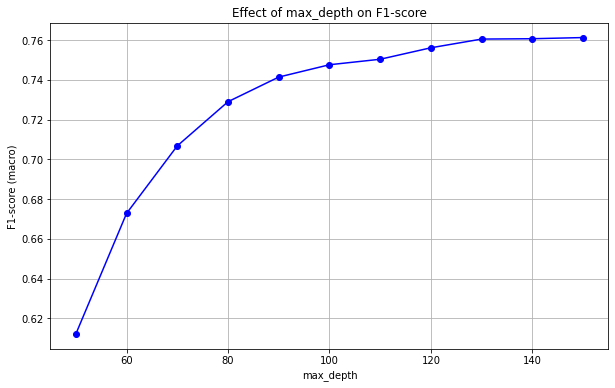

In [5]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt

# Load stop words from file
with open('sw_fr.txt', 'r', encoding='utf-8') as file:
    stop_words = [line.strip() for line in file]

# Load training data
train_data = pd.read_csv('output_fr.csv')

# Load test data
test_data = pd.read_csv('test_fr.csv')

# Define features (X) and target variable (y) for training data
X_train = train_data['Text']
y_train = train_data['Label']

# Define features (X) and target variable (y) for test data
X_test = test_data['Text']
y_test = test_data['Label']

# Create CountVectorizer with custom French stop words
vectorizer = CountVectorizer(
    stop_words=stop_words
)

# Fit and transform the training data
X_train_count = vectorizer.fit_transform(X_train)

# Transform the test data
X_test_count = vectorizer.transform(X_test)

# Initialize RandomForestClassifier
n_estimators = 100

# Lists to store F-scores and corresponding parameter values
max_depth_values = []
f1_scores = []

# Iterate over max_depth values
for max_depth in range(50, 151, 10):
    # Initialize RandomForestClassifier with the current parameters
    random_forest = RandomForestClassifier(random_state=42, n_estimators=n_estimators, max_depth=max_depth)

    # Train the model on the training set
    random_forest.fit(X_train_count, y_train)

    # Make predictions on the test set
    y_pred = random_forest.predict(X_test_count)

    # Get F1-score (macro) for the current model
    current_f1_score = f1_score(y_test, y_pred, average='macro')

    # Store values in lists
    max_depth_values.append(max_depth)
    f1_scores.append(current_f1_score)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, f1_scores, marker='o', linestyle='-', color='b')
plt.title('Effect of max_depth on F1-score')
plt.xlabel('max_depth')
plt.ylabel('F1-score (macro)')
plt.grid(True)
plt.show()


## Multi-Class Classifier

In [12]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Load stop words from file
with open('sw_fr.txt', 'r', encoding='utf-8') as file:
    stop_words = [line.strip() for line in file]

# Load training data
train_data = pd.read_csv('output_fr.csv')

# Load test data
test_data = pd.read_csv('test_fr.csv')

# Define features (X) and target variable (y) for training data
X_train = train_data['Text']
y_train = train_data['Label']

# Define features (X) and target variable (y) for test data
X_test = test_data['Text']
y_test = test_data['Label']

# Create CountVectorizer with custom French stop words
vectorizer = CountVectorizer(
    stop_words=stop_words
)

# Fit and transform the training data
X_train_count = vectorizer.fit_transform(X_train)

# Transform the test data
X_test_count = vectorizer.transform(X_test)

# Initialize RandomForestClassifier
random_forest = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=90)

# Train the model on the training set
random_forest.fit(X_train_count, y_train)

# Make predictions on the test set
y_pred = random_forest.predict(X_test_count)

# Get classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)


/home/yidi/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['quelqu'] not in stop_words.
  warnings.warn(


Classification Report:
               precision    recall  f1-score   support

        ELDR       1.00      0.54      0.70      1339
     GUE-NGL       0.97      0.69      0.81      1793
      PPE-DE       0.60      0.96      0.74      4571
         PSE       0.87      0.65      0.75      3627
   Verts-ALE       1.00      0.55      0.71      1585

    accuracy                           0.74     12915
   macro avg       0.89      0.68      0.74     12915
weighted avg       0.82      0.74      0.74     12915

